In [1]:
import torch
import torch.nn as nn

class ForwardProcess(nn.Module):
    def __init__(self, T, beta_start, beta_end):
        super(ForwardProcess, self).__init__()
        self.T = T
        self.betas = torch.linspace(beta_start, beta_end, T)
        self.alphas = 1. - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def forward(self, x_0, t):
        noise = torch.randn_like(x_0)
        alpha_bar_t = self.alpha_bars[t]
        x_t = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * noise
        return x_t, noise

In [2]:
class ReverseProcess(nn.Module):
    def __init__(self, model, T, beta_start, beta_end):
        super(ReverseProcess, self).__init__()
        self.model = model
        self.T = T
        self.betas = torch.linspace(beta_start, beta_end, T)
        self.alphas = 1. - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def forward(self, x_t, t):
        predicted_noise = self.model(x_t, t)
        alpha_t = self.alphas[t]
        alpha_bar_t = self.alpha_bars[t]
        x_prev = (x_t - (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t) * predicted_noise) / torch.sqrt(alpha_t)
        return x_prev

In [3]:
def train(model, dataloader, optimizer, forward_process, T, epochs):
    model.train()
    for epoch in range(epochs):
        for batch in dataloader:
            x_0 = batch
            t = torch.randint(0, T, (x_0.shape[0],))
            x_t, noise = forward_process(x_0, t)
            predicted_noise = model(x_t, t)
            loss = nn.MSELoss()(predicted_noise, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

In [4]:
def generate(model, reverse_process, T, shape):
    model.eval()
    x_t = torch.randn(shape)
    for t in range(T-1, -1, -1):
        x_t = reverse_process(x_t, t)
    return x_t

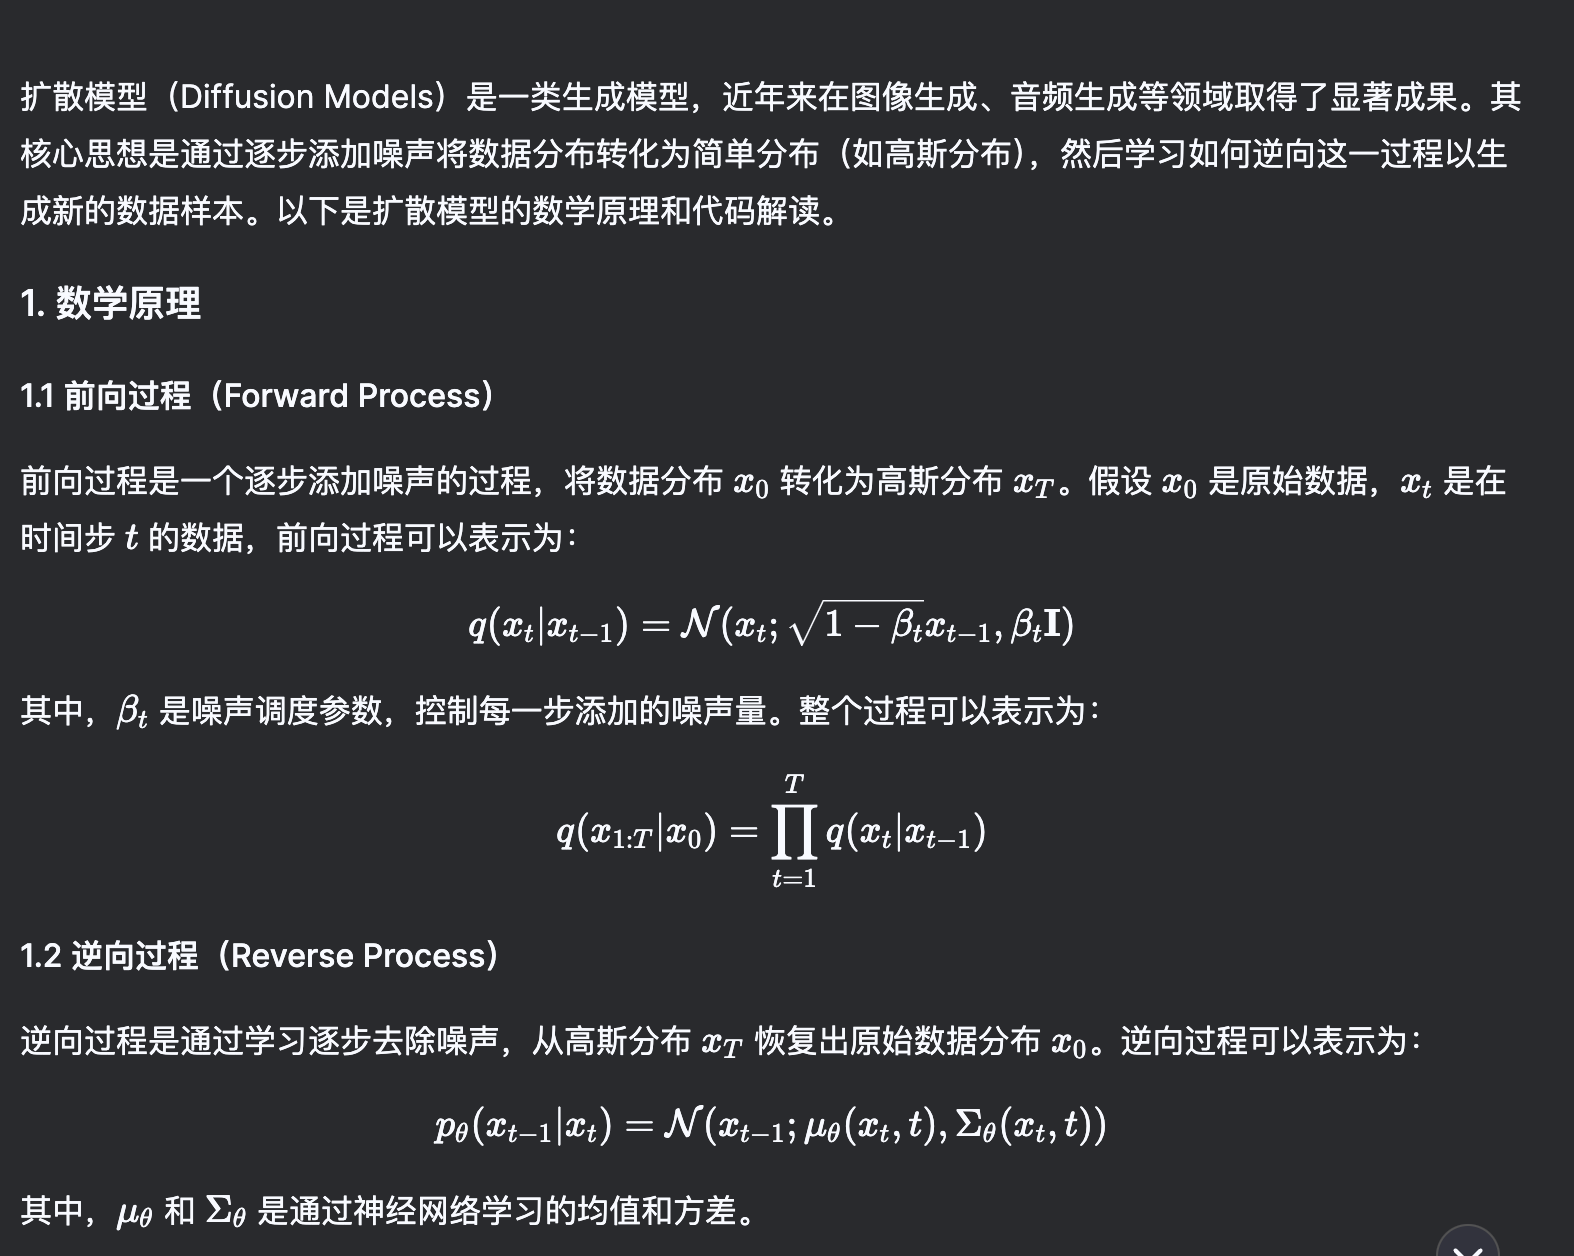

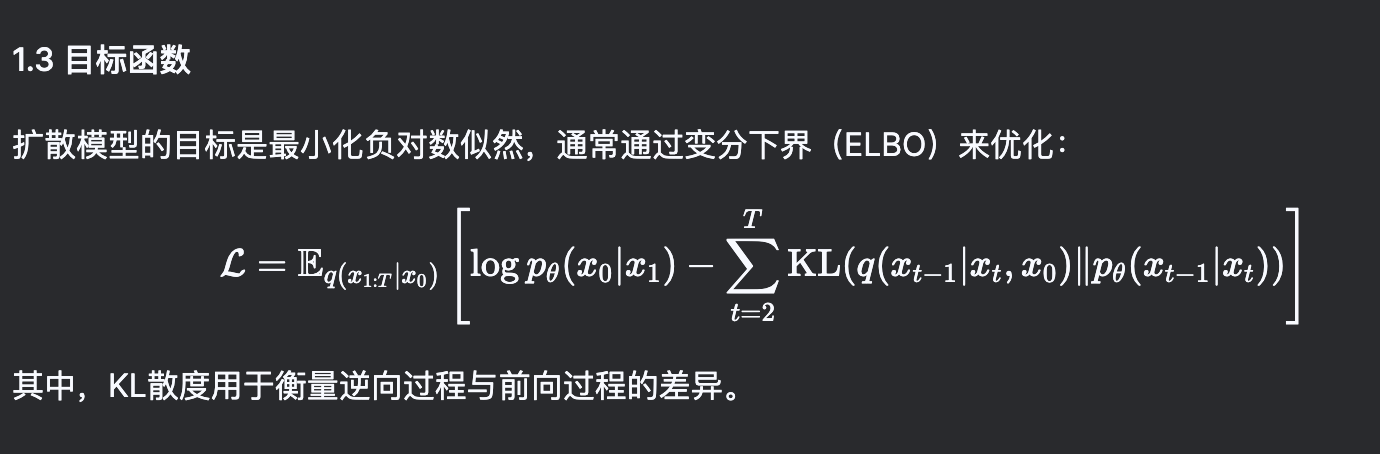